In [1]:
import pandas as pd
import numpy as np
import multiprocessing as mp
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from gensim import corpora
from gensim.models import LdaModel
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import ParameterGrid
from gensim.models.coherencemodel import CoherenceModel
from sklearn.model_selection import train_test_split
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from sklearn.metrics.pairwise import cosine_similarity
import random
import re

In [2]:
df = pd.read_csv('X_clean.csv')

Clean empty text form prepross

In [3]:
df.isna().sum()

Unnamed: 0                 0
title                      0
body                       0
score                      0
tags                       0
creation_date              0
is_english                 0
cleaned_title            183
cleaned_title_strict    1950
dl_title                   0
dl_body                    0
lm                       183
dtype: int64

In [4]:
df = df.dropna()

In [ ]:
def prepare_for_lda(df, target_column):
    """
    Prepares the text data from a DataFrame for Latent Dirichlet Allocation (LDA) modeling.

    Parameters:
    - df (pd.DataFrame): The input DataFrame containing the text data.
    - target_column (str): The name of the column in the DataFrame containing the text to process.

    Returns:
    - dictionary (gensim.corpora.Dictionary): A mapping of words to unique integer IDs.
    - corpus (list of list of tuples): A bag-of-words representation of the text data, 
      where each tuple contains a word ID and its frequency in a document.

    Functionality:
    - Splits the text in the specified column into tokens (words) if it is a string.
    - Creates a Gensim dictionary mapping unique words to IDs.
    - Converts the tokenized text into a bag-of-words format for LDA input.

    Notes:
    - The function modifies the DataFrame by adding a new column, 'cleaned_title_split', 
      which contains the tokenized text.
    - The dictionary and corpus returned can be used as inputs for LDA modeling.
    
    Example:
    >>> dictionary, corpus = prepare_for_lda(df, 'cleaned_title')
    >>> print(dictionary)
    >>> print(corpus)
    """
    df['cleaned_title_split'] = df[target_column].apply(lambda x: x.split() if isinstance(x, str) else x)
    
    dictionary = corpora.Dictionary(df['cleaned_title_split'])
    
    corpus = [dictionary.doc2bow(text) for text in df['cleaned_title_split']]
    
    print(dictionary)
    print(corpus)
    
    return dictionary, corpus


In [ ]:
def get_topic_distribution(lda_model, corpus, nb_topic):
    """
    Generates topic distributions for each document in the corpus based on the LDA model.

    Parameters:
    - lda_model: Trained LDA model.
    - corpus: Bag-of-words representation of the documents.
    - nb_topic: Number of topics in the LDA model.

    Returns:
    - np.ndarray: A 2D array where each row corresponds to a document and each column represents 
                  the probability distribution of topics for that document.
    """
    doc_topic_distributions = [lda_model.get_document_topics(bow) for bow in corpus]
    topic_vectors = np.zeros((len(doc_topic_distributions), nb_topic))
    for i, doc in enumerate(doc_topic_distributions):
        for topic_id, prob in doc:
            topic_vectors[i, topic_id] = prob
    return topic_vectors


def print_TSNE(topic_vectors):
    """
    Visualizes the topic distribution in a 2D space using t-SNE.

    Parameters:
    - topic_vectors (np.ndarray): A 2D array where each row corresponds to a document's topic distribution.

    Returns:
    - None. Displays a t-SNE scatter plot.
    """
    tsne_model = TSNE(n_components=2, random_state=42)
    tsne_values = tsne_model.fit_transform(topic_vectors)
    plt.figure(figsize=(8, 8))
    plt.scatter(tsne_values[:, 0], tsne_values[:, 1], c=np.argmax(topic_vectors, axis=1), cmap='viridis')
    plt.colorbar(label='Topic')
    plt.title('2D visualization of LDA topic distribution using t-SNE')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()


def print_PCA(topic_vectors):
    """
    Visualizes the topic distribution in a 2D space using PCA.

    Parameters:
    - topic_vectors (np.ndarray): A 2D array where each row corresponds to a document's topic distribution.

    Returns:
    - None. Displays a PCA scatter plot.
    """
    pca_model = PCA(n_components=2)
    pca_values = pca_model.fit_transform(topic_vectors)
    plt.figure(figsize=(8, 8))
    plt.scatter(pca_values[:, 0], pca_values[:, 1], c=np.argmax(topic_vectors, axis=1), cmap='viridis')
    plt.colorbar(label='Topic')
    plt.title('2D visualization of LDA topic distribution using PCA')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()


def get_best_lda_model(dictionary, corpus, grid, texts):
    """
    Finds the best LDA model based on coherence and perplexity scores.

    Parameters:
    - dictionary (gensim.corpora.Dictionary): Gensim dictionary mapping words to their IDs.
    - corpus (list of list of tuples): Bag-of-words representation of the documents.
    - grid (list of dict): Grid of hyperparameters to search over, with keys 'num_topics' and 'passes'.
    - texts (list of list of str): List of tokenized documents for coherence calculation.

    Returns:
    - best_model (LdaModel): The LDA model with the best coherence score.
    - int: The number of topics in the best model.
    """
    best_coherence = -1
    best_perplexity = 2**32
    best_params = None
    best_model = None

    for params in grid:
        lda_model = LdaModel(corpus=corpus,
                             id2word=dictionary,
                             num_topics=params['num_topics'],
                             passes=params['passes'])

        coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model_lda.get_coherence()
        perplexity = lda_model.log_perplexity(corpus)

        print(f"Topics: {params['num_topics']}, Passes: {params['passes']} -> Coherence: {coherence_score} Perplexity: {perplexity}")

        if coherence_score > best_coherence:
            best_coherence = coherence_score
            best_params = params
            best_model = lda_model
            best_perplexity = perplexity

    print(f"Best Coherence Score: {best_coherence}, have Perplexity: {best_perplexity} with Parameters: {best_params}")
    return best_model, int(best_params['num_topics'])


In [7]:
train_data, test_data = train_test_split(df, test_size=0.2)
dictionary, corpus = prepare_for_lda(train_data, 'cleaned_title_strict')

Dictionary<2454 unique tokens: ['angular', 'bundle', 'gulp', 'typescript', 'dart']...>
[[(0, 1), (1, 1), (2, 1), (3, 1)], [(3, 1)], [(4, 1)], [(5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1)], [(11, 1), (12, 1), (13, 1)], [(14, 1), (15, 1)], [(16, 1), (17, 1)], [(18, 1), (19, 1), (20, 1)], [(3, 1)], [(21, 1), (22, 1), (23, 1), (24, 1)], [(25, 1), (26, 1), (27, 2)], [(28, 1), (29, 1), (30, 1), (31, 1), (32, 1)], [(33, 1), (34, 1)], [(35, 1), (36, 1)], [(37, 1), (38, 1), (39, 1), (40, 1)], [(41, 1), (42, 1)], [(43, 1), (44, 1), (45, 1)], [(46, 1)], [(35, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1)], [(3, 1), (52, 1)], [(53, 1), (54, 1)], [(55, 1)], [(11, 1)], [(56, 1)], [(57, 1), (58, 1)], [(31, 1), (59, 1), (60, 1), (61, 1)], [(54, 1), (62, 1), (63, 1), (64, 1), (65, 1)], [(66, 1)], [(67, 1), (68, 1), (69, 1)], [(70, 1)], [(71, 1), (72, 1)], [(73, 1), (74, 1)], [(75, 1), (76, 1)], [(5, 1), (77, 1)], [(36, 1), (78, 1), (79, 1)], [(14, 1), (80, 1), (81, 1)], [(25, 1), (26, 1)], [(82, 

In [8]:
print(dictionary.token2id)

{'angular': 0, 'bundle': 1, 'gulp': 2, 'typescript': 3, 'dart': 4, 'environment': 5, 'firebase': 6, 'google': 7, 'ios': 8, 'notifications': 9, 'production': 10, 'java': 11, 'lambda': 12, 'lists': 13, 'python': 14, 'series': 15, 'email': 16, 'swiftui': 17, 'hook': 18, 'product': 19, 'woocommerce': 20, 'apps': 21, 'browser': 22, 'native': 23, 'react': 24, 'api': 25, 'rest': 26, 'web': 27, 'cordova': 28, 'deploy': 29, 'devices': 30, 'studio': 31, 'visual': 32, 'nextjs': 33, 'refresh': 34, 'chrome': 35, 'feature': 36, 'django': 37, 'jwt': 38, 'modifying': 39, 'token': 40, 'actually': 41, 'future': 42, 'azure': 43, 'binary': 44, 'serve': 45, 'render': 46, 'ajax': 47, 'jquery': 48, 'pending': 49, 'request': 50, 'stuck': 51, 'importing': 52, 'dataframe': 53, 'pyspark': 54, 'boot': 55, 'completely': 56, 'grouped': 57, 'plot': 58, 'android': 59, 'containing': 60, 'deprecation': 61, 'fit': 62, 'improve': 63, 'jupyter': 64, 'notebook': 65, 'pool': 66, 'explorer': 67, 'flexbox': 68, 'internet': 69

After many tries with from 10 to 40 num_topics 40 have a better silhouet score, but it's not ok the words in the topics, 11 have good silhouet score and a better understanding in the words inside the topics

In [ ]:
param_grid = {
    'num_topics': [11],
    'passes': [10]
}

grid = ParameterGrid(param_grid)
best_lda, nb_topic = get_best_lda_model(dictionary, corpus, grid, train_data['cleaned_title_split'])
topic_vectors = get_topic_distribution(best_lda, corpus, nb_topic)

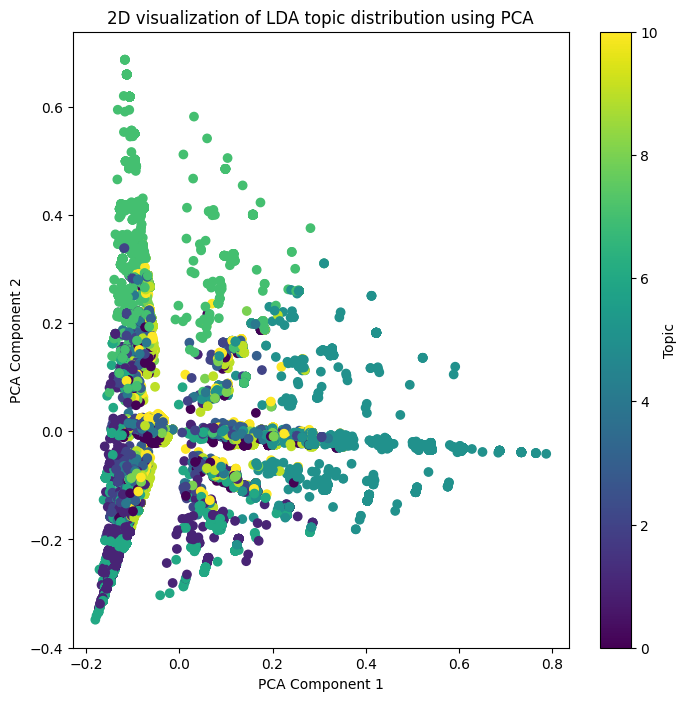

In [ ]:
print_PCA(topic_vectors)

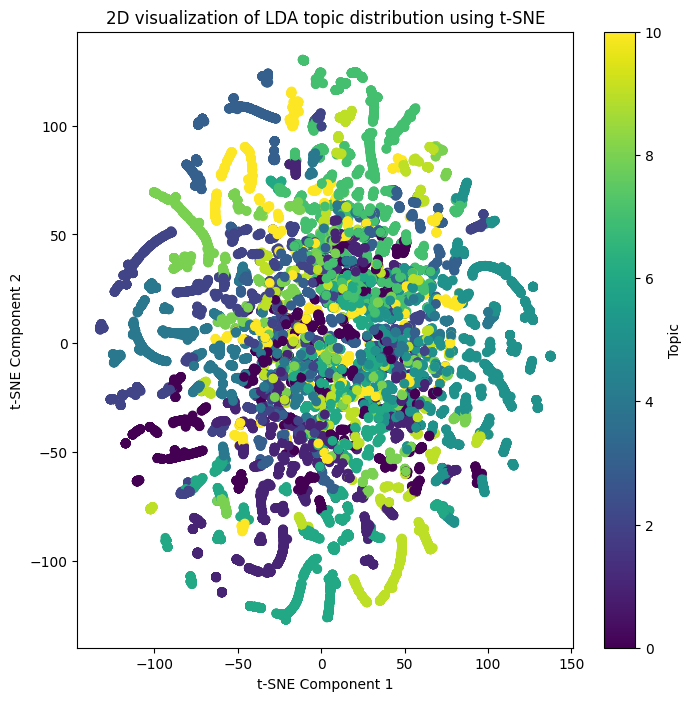

In [ ]:
print_TSNE(topic_vectors)

In [ ]:
best_lda.print_topics()

[(0,
  '0.047*"typescript" + 0.042*"chrome" + 0.039*"css" + 0.027*"jest" + 0.024*"webpack" + 0.023*"mock" + 0.022*"environment" + 0.020*"scroll" + 0.020*"notebook" + 0.020*"jupyter"'),
 (1,
  '0.150*"android" + 0.097*"angular" + 0.077*"studio" + 0.039*"visual" + 0.027*"gradle" + 0.013*"pytorch" + 0.013*"node" + 0.012*"interface" + 0.012*"pointer" + 0.011*"cli"'),
 (2,
  '0.095*"react" + 0.081*"java" + 0.044*"request" + 0.033*"native" + 0.028*"http" + 0.016*"pip" + 0.015*"r" + 0.013*"maven" + 0.013*"components" + 0.013*"recyclerview"'),
 (3,
  '0.097*"swift" + 0.049*"xcode" + 0.036*"spark" + 0.031*"google" + 0.025*"ios" + 0.019*"browser" + 0.011*"production" + 0.011*"protocol" + 0.010*"router" + 0.009*"ie"'),
 (4,
  '0.092*"pandas" + 0.055*"dataframe" + 0.053*"laravel" + 0.036*"x" + 0.020*"linux" + 0.014*"merge" + 0.014*"database" + 0.014*"window" + 0.014*"cors" + 0.013*"already"'),
 (5,
  '0.049*"api" + 0.045*"flutter" + 0.044*"json" + 0.039*"c+" + 0.039*"aws" + 0.036*"ios" + 0.031*"dj

In [ ]:
vis_data = gensimvis.prepare(best_lda, corpus, dictionary)
pyLDAvis.display(vis_data)
pyLDAvis.save_html(vis_data, 'lda_visualization.html')

ValidationError: 
 * Not all rows (distributions) in topic_term_dists sum to 1.

In [ ]:
def tag_coverage_rate(real_tags, proposed_tags):
    """
    Calculate the tag coverage rate.
    
    Args:
        real_tags (list of list of str): Real tags for each question.
        proposed_tags (list of list of str): Proposed tags for each question.
    
    Returns:
        float: Average tag coverage rate.
    """
    coverage_rates = []
    
    for real, proposed in zip(real_tags, proposed_tags):
        if real:
            coverage = len(set(real).intersection(set(proposed))) / len(real)
            coverage_rates.append(coverage)
    
    return sum(coverage_rates) / len(coverage_rates) if coverage_rates else 0

def question_word_coverage_rate(cleaned_titles, proposed_tags):
    """
    Calculate the question word coverage rate.
    
    Args:
        cleaned_titles (list of str): A list of cleaned titles (questions).
        proposed_tags (list of list of str): Proposed tags for each question.
    
    Returns:
        float: Average question word coverage rate.
    """
    
    coverage_rates = []
    
    for title, proposed in zip(cleaned_titles, proposed_tags):
        question_words = set(re.findall(r'\w+', title.lower()))
        if question_words:
            coverage = len(question_words.intersection(set(proposed))) / len(question_words)
            coverage_rates.append(coverage)
    
    return sum(coverage_rates) / len(coverage_rates) if coverage_rates else 0

def visual_check(titles, proposed_tags, sample_size=5):
    """
    Print a sample of cleaned titles with proposed keywords for visual check.
    
    Args:
        titles (pd.Series or list of str): A Series or list of cleaned titles (questions).
        proposed_tags (pd.Series or list of list of str): A Series or list of proposed tags for each question.
        sample_size (int): Number of questions to display.
    """
    if isinstance(titles, pd.Series):
        titles = titles.tolist()
    if isinstance(proposed_tags, pd.Series):
        proposed_tags = proposed_tags.tolist()
    
    sample_indices = random.sample(range(len(titles)), sample_size)
    
    for i in sample_indices:
        print(f"Question (Cleaned Title): {titles[i]}")
        print(f"Proposed Keywords: {proposed_tags[i]}")
        print("-" * 40)



In [ ]:
def build_proposed_tags_with_corpus(corpus, best_lda, num_keywords=10):
    """
    Generate proposed tags based on the best LDA model for each question, using precomputed corpus.
    
    Args:
        corpus (list of list of tuple): Bag-of-words format for each question (prepared using dictionary).
        best_lda (gensim.models.LdaModel): Trained LDA model.
        num_keywords (int): Number of top keywords to use as tags per question.
    
    Returns:
        list of list of str: Proposed tags for each question.
    """
    proposed_tags = []
    for bow in corpus:
        topic_dist = best_lda[bow]
        dominant_topic = max(topic_dist, key=lambda x: x[1])[0]
        topic_keywords = [word for word, _ in best_lda.show_topic(dominant_topic, topn=num_keywords)]
        proposed_tags.append(topic_keywords)
    return proposed_tags

In [ ]:
dictionary, corpus = prepare_for_lda(test_data, 'cleaned_title_strict')
test_data['proposed_tags'] = build_proposed_tags_with_corpus(corpus, best_lda)

Dictionary<2273 unique tokens: ['junit', 'mock', 'autolayout', 'uistackview', 'xcode']...>
[[(0, 1), (1, 1)], [(2, 1), (3, 1), (4, 1)], [(5, 1), (6, 1)], [(7, 1), (8, 1)], [(9, 1)], [(10, 1)], [(11, 1)], [(12, 1)], [(13, 1), (14, 1), (15, 1), (16, 1)], [(12, 1)], [(13, 1), (17, 1), (18, 1), (19, 1)], [(20, 1), (21, 1), (22, 1)], [(23, 1), (24, 1), (25, 1)], [(26, 1), (27, 1), (28, 1), (29, 1)], [(30, 1)], [(31, 1), (32, 1)], [(33, 1)], [(34, 1), (35, 1), (36, 1)], [(37, 1)], [(29, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1)], [(37, 1), (43, 1), (44, 1)], [(29, 1), (45, 1), (46, 1)], [(47, 1)], [(48, 1)], [(14, 1), (49, 1), (50, 1)], [(51, 1), (52, 1)], [(53, 1), (54, 1), (55, 1), (56, 1)], [(57, 1), (58, 1), (59, 1), (60, 1)], [(61, 1), (62, 1)], [(63, 1), (64, 1)], [(53, 1), (65, 1), (66, 1)], [(67, 1), (68, 1), (69, 1), (70, 1)], [(53, 1), (71, 1), (72, 1), (73, 1)], [(26, 1), (74, 1), (75, 1)], [(76, 1)], [(77, 1), (78, 1), (79, 1)], [(64, 2), (80, 1)], [(81, 1)], [(82, 1), (83,

In [ ]:
tag_coverage_rate(test_data['tags'], test_data['proposed_tags'])

0.0005754247758453612

If I try the coverage rate of actual tags from data and proposed_tags, it show a very low coverage

In [ ]:
question_word_coverage_rate(test_data['title'], test_data['proposed_tags'])

0.005374025832518099

If I look the coverage from proposed tag to the title is still low but better

In [ ]:
question_word_coverage_rate(test_data['cleaned_title_strict'], test_data['proposed_tags'])

0.016199211766617913

If I look the coverage from proposed tag to the strict_title is still low but better

In [ ]:
visual_check(test_data['title'], test_data['proposed_tags'])

Question (Cleaned Title): Why does the node inspector not start when I am using nodemon and ts-node?
Proposed Keywords: ['python', 'vs', 'aspnet', 'component', 'html']
----------------------------------------
Question (Cleaned Title): detect whether ES Module is run from command line in Node
Proposed Keywords: ['javascript', 'net', 'c#', 'pyspark', 'firestore']
----------------------------------------
Question (Cleaned Title): Updating integer column with null values in postgres
Proposed Keywords: ['pandas', 'dataframe', 'laravel', 'x', 'linux']
----------------------------------------
Question (Cleaned Title): aws-sdk: crash after updating from angular5 to angular6
Proposed Keywords: ['api', 'flutter', 'json', 'c+', 'aws']
----------------------------------------
Question (Cleaned Title): How to set default values in ng-select in angular6?
Proposed Keywords: ['api', 'flutter', 'json', 'c+', 'aws']
----------------------------------------


The proposed tag are not relevant, we can't keep this solucions for the project